In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l2
import optuna
import warnings


In [6]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range for the full dataset
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset
data = yf.download(ticker, start=start_date, end=end_date)

# Check for missing values and handle them
data = data.dropna()

print(pd.concat([data.head(1), data.tail(1)]))


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


In [7]:
# Extract the closing prices
X = data[['Close']]

# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set
train, test = train_test_split(X=data['Close'], size=0.8)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
sc_data = scaler.fit_transform(train.values.reshape(-1, 1))

# Define function to prepare the data
def prepare_data(seq_len, data):
    X = np.array([data[i:i+seq_len, :] for i in range(data.shape[0] - seq_len)])
    y = np.array([data[i+seq_len, 0] for i in range(data.shape[0] - seq_len)])  # Predicting ARIMA residuals
    return X, y

In [8]:
# Create an SQLite database to store the study
study_name = 'hyperparameter_LSTM'
storage_name = f'sqlite:///{study_name}.db'

# Create an Optuna study with the SQLite storage
study = optuna.create_study(direction='minimize', storage=storage_name, study_name=study_name, load_if_exists=True)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized (excluding batch size and epochs)
    seq_len = trial.suggest_int('seq_len', 2, 10)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    units_list = [trial.suggest_int(f'units_l{i}', 32, 128) for i in range(num_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['linear', 'relu', 'sigmoid'])
    
    # Fixed batch size and epochs
    batch_size = 32
    epochs = 100
    
    # Prepare the data using the suggested sequence length
    X_train, y_train = prepare_data(seq_len, sc_data)

    # Create the LSTM model with the suggested hyperparameters
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=units_list[0], input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=(num_layers > 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for i in range(1, num_layers):
        model.add(LSTM(units=units_list[i], return_sequences=(i < num_layers - 1), kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation=activation))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=20)
    val_loss_list = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=0,
                            callbacks=[early_stopping])
        
        # Get the validation loss
        val_loss = min(history.history['val_loss'])
        val_loss_list.append(val_loss)
    
    # Return the average validation loss across folds
    return np.mean(val_loss_list)

# Optimize the study
study.optimize(objective, n_trials=50)

[I 2024-08-25 14:51:48,263] A new study created in RDB with name: hyperparameter_LSTM
[I 2024-08-25 15:03:02,387] Trial 0 finished with value: 0.007106246161856689 and parameters: {'seq_len': 8, 'num_layers': 2, 'units_l0': 113, 'units_l1': 40, 'dropout_rate': 0.49475845721763145, 'l2_reg': 2.8578321720975564e-05, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.007106246161856689.
[I 2024-08-25 15:07:39,428] Trial 1 finished with value: 0.006825230667891447 and parameters: {'seq_len': 3, 'num_layers': 2, 'units_l0': 107, 'units_l1': 109, 'dropout_rate': 0.4431779371330581, 'l2_reg': 9.229316648103151e-05, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.006825230667891447.
[I 2024-08-25 15:10:25,899] Trial 2 finished with value: 0.0013846371050021844 and parameters: {'seq_len': 7, 'num_layers': 1, 'units_l0': 110, 'dropout_rate': 0.28607756194676026, 'l2_reg': 1.4353823862158224e-05, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.0013846371050021844.
[I 2024-08-

In [13]:
# Load the Optuna study from the SQLite database
study_name='hyperparameter_LSTM'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.load_study(study_name=study_name, storage=storage_name)

# Extract the best trial's hyperparameters
best_trial = study.best_trial
seq_len = best_trial.params['seq_len']
layers = best_trial.params['num_layers']
dropout_rate = best_trial.params['dropout_rate']
l2_reg = best_trial.params['l2_reg']
activation = best_trial.params['activation']

# Extract units for each layer based on the number of layers
units = [best_trial.params[f'units_l{i}'] for i in range(layers)]

# Fixed parameters
epochs = 100
batch_size = 32

# Prepare data for LSTM model using the best sequence length
X_train, y_train = prepare_data(seq_len, sc_data)

print(X_train.shape, y_train.shape)

# Define the LSTM model with optimal hyperparameters
model = Sequential()

# First LSTM layer with return_sequences=True if layers > 1
model.add(LSTM(units=units[0], input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=(layers > 1), kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))  # Dropout layer

# If there are multiple layers, add more LSTM and Dropout layers
for i in range(1, layers):
    model.add(LSTM(units=units[i], return_sequences=(i < layers - 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))  # Dropout layer

# Output layer with the specified activation function
model.add(Dense(1, activation=activation))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()


(1940, 4, 1) (1940,)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 54)                12096     
                                                                 
 dropout_68 (Dropout)        (None, 54)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 55        
                                                                 
Total params: 12,151
Trainable params: 12,151
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Print the best trial's value (objective value)
print(f"Best trial value (loss): {best_trial.value}")

# Print the hyperparameters of the best trial
print("Best trial hyperparameters:")
for param_name, param_value in best_trial.params.items():
    print(f"  {param_name}: {param_value}")

Best trial value (loss): 0.0003892905910106492
Best trial hyperparameters:
  seq_len: 4
  num_layers: 1
  units_l0: 54
  dropout_rate: 0.15472154229912094
  l2_reg: 1.8190381292475814e-05
  activation: linear


In [19]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

Epoch 1/100
49/49 - 1s - loss: 3.4638e-04 - val_loss: 1.3843e-04 - 759ms/epoch - 15ms/step
Epoch 2/100
49/49 - 1s - loss: 3.7827e-04 - val_loss: 1.4055e-04 - 776ms/epoch - 16ms/step
Epoch 3/100
49/49 - 1s - loss: 3.7230e-04 - val_loss: 1.4641e-04 - 1s/epoch - 21ms/step
Epoch 4/100
49/49 - 1s - loss: 3.6177e-04 - val_loss: 1.3600e-04 - 892ms/epoch - 18ms/step
Epoch 5/100
49/49 - 1s - loss: 3.5340e-04 - val_loss: 1.4191e-04 - 700ms/epoch - 14ms/step
Epoch 6/100
49/49 - 1s - loss: 3.4712e-04 - val_loss: 1.3739e-04 - 694ms/epoch - 14ms/step
Epoch 7/100
49/49 - 1s - loss: 3.4341e-04 - val_loss: 1.3975e-04 - 738ms/epoch - 15ms/step
Epoch 8/100
49/49 - 1s - loss: 3.8013e-04 - val_loss: 1.5835e-04 - 670ms/epoch - 14ms/step
Epoch 9/100
49/49 - 1s - loss: 3.9367e-04 - val_loss: 1.3745e-04 - 665ms/epoch - 14ms/step
1/1 [==============================] - 0s 63ms/step
Epoch 1/100
49/49 - 1s - loss: 3.6210e-04 - val_loss: 1.9292e-04 - 899ms/epoch - 18ms/step
Epoch 2/100
49/49 - 1s - loss: 3.4941e-04

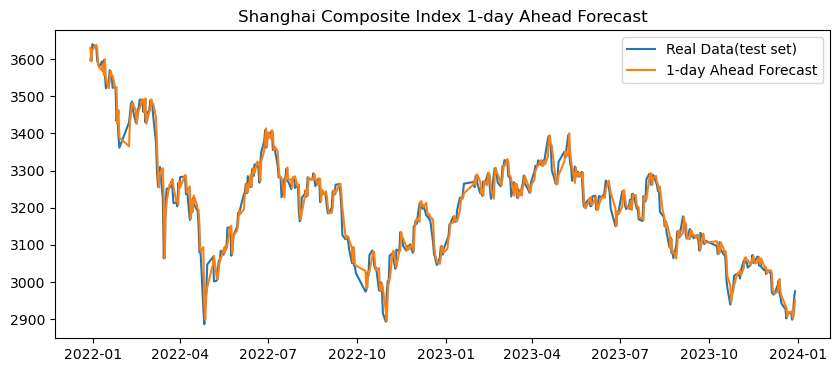

Epoch 1/100
49/49 - 1s - loss: 3.7620e-04 - val_loss: 2.0765e-04 - 722ms/epoch - 15ms/step
Epoch 2/100
49/49 - 1s - loss: 3.7653e-04 - val_loss: 1.3455e-04 - 621ms/epoch - 13ms/step
Epoch 3/100
49/49 - 1s - loss: 3.7952e-04 - val_loss: 1.3313e-04 - 554ms/epoch - 11ms/step
Epoch 4/100
49/49 - 1s - loss: 3.4951e-04 - val_loss: 1.4034e-04 - 614ms/epoch - 13ms/step
Epoch 5/100
49/49 - 1s - loss: 3.6176e-04 - val_loss: 1.4119e-04 - 533ms/epoch - 11ms/step
Epoch 6/100
49/49 - 1s - loss: 3.3542e-04 - val_loss: 1.3360e-04 - 716ms/epoch - 15ms/step
Epoch 7/100
49/49 - 1s - loss: 3.6685e-04 - val_loss: 1.3644e-04 - 771ms/epoch - 16ms/step
Epoch 8/100
49/49 - 1s - loss: 3.6249e-04 - val_loss: 1.4822e-04 - 648ms/epoch - 13ms/step
1/1 [==============================] - 0s 40ms/step
Epoch 1/100
49/49 - 1s - loss: 3.4438e-04 - val_loss: 1.2954e-04 - 681ms/epoch - 14ms/step
Epoch 2/100
49/49 - 1s - loss: 3.4845e-04 - val_loss: 1.3345e-04 - 595ms/epoch - 12ms/step
Epoch 3/100
49/49 - 1s - loss: 3.6052e

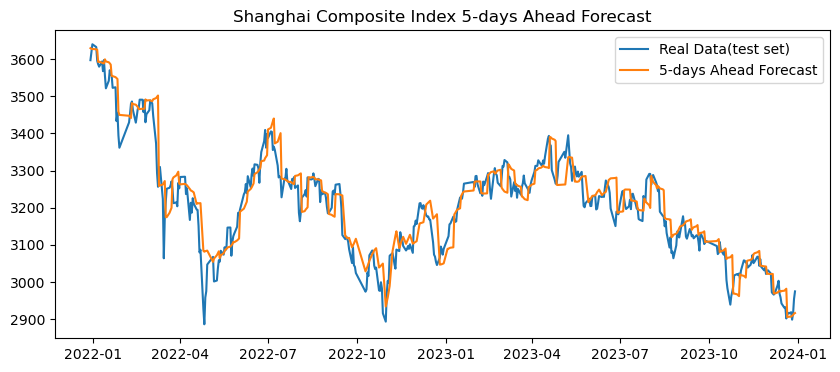

Epoch 1/100
49/49 - 1s - loss: 3.6713e-04 - val_loss: 1.3579e-04 - 1s/epoch - 23ms/step
Epoch 2/100
49/49 - 1s - loss: 3.6207e-04 - val_loss: 1.3918e-04 - 1s/epoch - 20ms/step
Epoch 3/100
49/49 - 1s - loss: 3.7216e-04 - val_loss: 1.3713e-04 - 1s/epoch - 22ms/step
Epoch 4/100
49/49 - 1s - loss: 3.1641e-04 - val_loss: 1.3293e-04 - 1s/epoch - 20ms/step
Epoch 5/100
49/49 - 1s - loss: 3.2952e-04 - val_loss: 1.3155e-04 - 1s/epoch - 21ms/step
Epoch 6/100
49/49 - 1s - loss: 3.3882e-04 - val_loss: 1.5925e-04 - 1s/epoch - 22ms/step
Epoch 7/100
49/49 - 1s - loss: 3.3611e-04 - val_loss: 1.8919e-04 - 1s/epoch - 22ms/step
Epoch 8/100
49/49 - 1s - loss: 3.5080e-04 - val_loss: 1.9331e-04 - 983ms/epoch - 20ms/step
Epoch 9/100
49/49 - 1s - loss: 3.7689e-04 - val_loss: 1.3814e-04 - 975ms/epoch - 20ms/step
Epoch 10/100
49/49 - 1s - loss: 3.4713e-04 - val_loss: 1.4010e-04 - 1s/epoch - 21ms/step
1/1 [==============================] - 0s 58ms/step
Epoch 1/100
50/50 - 1s - loss: 3.9836e-04 - val_loss: 1.2370e

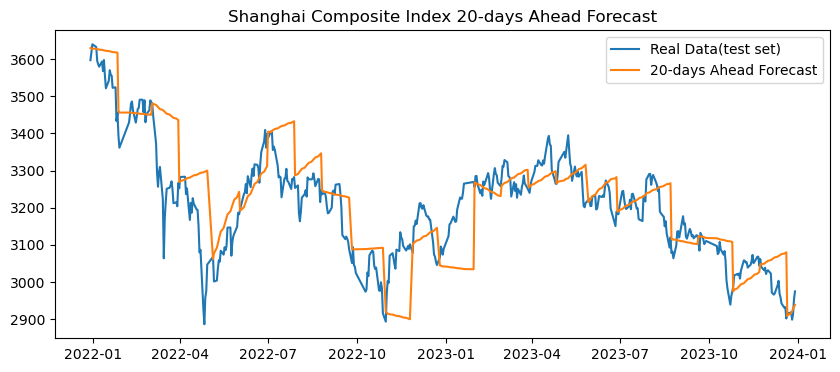

Epoch 1/100
49/49 - 2s - loss: 3.6092e-04 - val_loss: 1.6257e-04 - 2s/epoch - 33ms/step
Epoch 2/100
49/49 - 1s - loss: 3.3850e-04 - val_loss: 2.3176e-04 - 1s/epoch - 24ms/step
Epoch 3/100
49/49 - 1s - loss: 3.6731e-04 - val_loss: 1.3360e-04 - 1s/epoch - 23ms/step
Epoch 4/100
49/49 - 1s - loss: 3.2941e-04 - val_loss: 1.8813e-04 - 1s/epoch - 21ms/step
Epoch 5/100
49/49 - 1s - loss: 3.4033e-04 - val_loss: 1.2844e-04 - 996ms/epoch - 20ms/step
Epoch 6/100
49/49 - 1s - loss: 3.2614e-04 - val_loss: 2.1664e-04 - 924ms/epoch - 19ms/step
Epoch 7/100
49/49 - 1s - loss: 3.6261e-04 - val_loss: 1.4924e-04 - 1s/epoch - 22ms/step
Epoch 8/100
49/49 - 1s - loss: 3.4635e-04 - val_loss: 1.3732e-04 - 986ms/epoch - 20ms/step
Epoch 9/100
49/49 - 1s - loss: 3.8091e-04 - val_loss: 1.3269e-04 - 955ms/epoch - 19ms/step
Epoch 10/100
49/49 - 1s - loss: 3.6676e-04 - val_loss: 1.3455e-04 - 1s/epoch - 21ms/step
1/1 [==============================] - 0s 84ms/step
Epoch 1/100
52/52 - 1s - loss: 3.2184e-04 - val_loss: 1

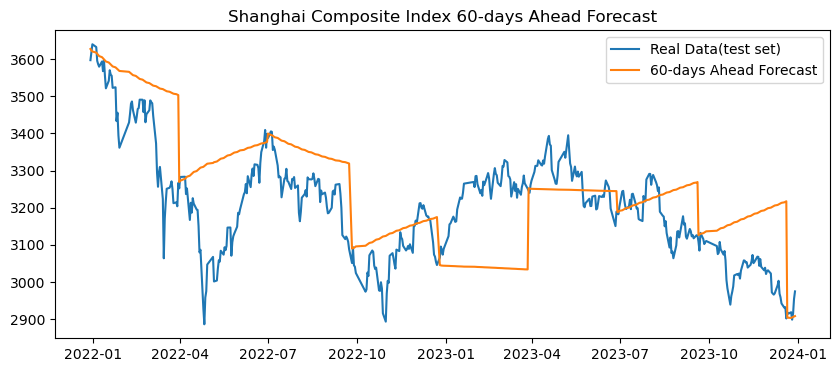

1-day Ahead Forecast:
MAE: 22.345359015187668
RMSE: 30.222670335086733
MAPE: 0.6996719008475414%

5-days Ahead Forecast:
MAE: 36.759610345303386
RMSE: 50.13993345705163
MAPE: 1.1564142556230441%

20-days Ahead Forecast:
MAE: 67.882150345404
RMSE: 94.00050674070765
MAPE: 2.1438037338633356%

60-days Ahead Forecast:
MAE: 113.14573743147534
RMSE: 142.53497042251516
MAPE: 3.5741777237414194%



In [18]:
# Function to perform multi-step LSTM forecast
def one_step_lstm_forecast(X_last, n_periods=1):
    lstm_forecasts = []
    
    for _ in range(n_periods):
        last_np = X_last[-seq_len:].reshape(1, seq_len, 1)
        last_scaled = scaler.transform(last_np.reshape(-1, 1)).reshape(1, seq_len, 1)
        lstm_forecast_scaled = model.predict(last_scaled)[0, 0]
        lstm_forecast = scaler.inverse_transform([[lstm_forecast_scaled]])[0, 0]
        lstm_forecasts.append(lstm_forecast)
        X_last = np.append(X_last, lstm_forecast).reshape(-1, 1)
    
    return lstm_forecasts

# Function to retrain the LSTM model
def retrain_lstm(train):
    lstm_data = train.values.reshape(-1, 1)
    sc_data = scaler.fit_transform(lstm_data)
    X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
    y_train = np.array([sc_data[i + seq_len, 0] for i in range(sc_data.shape[0] - seq_len)])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

# Perform forecasts and evaluations for different periods
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

for period_name, n_periods in forecast_periods.items():
    lstm_predictions = []
    current_train = train.copy()
    # Define the LSTM model for each time horizon
    retrain_lstm(current_train)
    
    for i in range(0, len(test), n_periods):
        # Perform  forecast
        lstm_forecasts = one_step_lstm_forecast(current_train.values, n_periods=n_periods)
        
        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                lstm_predictions.append(lstm_forecasts[j])
                
        # Update the training sets with new observed data
        current_train = pd.concat([current_train, test[i:i+n_periods]])
        
        # Retrain the LSTM model based on the forecast period
        if period_name == '1-day' and (i + n_periods) % 5 == 0:
            retrain_lstm(current_train)
        elif period_name == '5-days' and (i + n_periods) % (5 * 2) == 0:  
            retrain_lstm(current_train)
        elif period_name == '20-days' and (i + n_periods) % (20 * 2) == 0:  
            retrain_lstm(current_train)
        elif period_name == '60-days' and (i + n_periods) % (60 * 2) == 0:  
            retrain_lstm(current_train)
    
    # Sort LSTM Forecasts
    lstm_forecast_series = pd.Series(lstm_predictions[:len(test)], index=test.index[:len(lstm_predictions)])
    
    mae = mean_absolute_error(test[:len(lstm_forecast_series)], lstm_forecast_series)
    rmse = np.sqrt(mean_squared_error(test[:len(lstm_forecast_series)], lstm_forecast_series))
    mape = np.mean(np.abs((test[:len(lstm_forecast_series)] - lstm_forecast_series) / test[:len(lstm_forecast_series)])) * 100

    results[period_name] = {
        'forecast': lstm_forecast_series,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print(f'{period_name.capitalize()} Ahead Forecast:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%\n')

    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(lstm_forecast_series, label=f'{period_name.capitalize()} Ahead Forecast')
    
    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast')
    plt.legend()
    plt.show()

# Summarize results for each forecasting period
for period_name, result in results.items():
    print(f"{period_name.capitalize()} Ahead Forecast:")
    print(f"MAE: {result['mae']}")
    print(f"RMSE: {result['rmse']}")
    print(f"MAPE: {result['mape']}%\n")
